### Index Long Side Strategy
- Time Frame: Daily
- RSI(7) - 7 periods
- SMA(8) & SMA(20)
- MACD(12,26,9)


#### Strategy Overview
- SMA, MACD are lagging trend indicators that help to identify the direction of the trend
- RSI is a leading momentum indicators that assesses general strength trend
- This strategy uses RSI as an early signal and SMA and MACD as a confirmation
- Bullish crossover happens when SMA8 > SMA20 and indicates upward trend
- We apply same time frame for both leading and lagging indicators (daily).

#### Entry Condition:

Signal: 
- If RSI(7) > 50
- Wait for x candles for either trend conditions to become true (confirmation)

Confirmation:
1. SMA(8) > SMA(20) (Bullish crossover) -> Long
2. MACD line crosses over the signal line (Uptrend) -> Long


#### Exit Conditions:

x = 5\
If SMA or MACD bullish cross up happens within x days, we will hold on to our positions. 


Exit condition 1:
- If SMA cross up or MACD do not happen within x days, we exit.

Exit Condition 2:
- If SMA cross up or MACD happens within x days, then hold position til either SMA cross down or MACD cross down (MACD histogram > 0)
- 4-5 years historical data

In [ ]:
import os
# print(os.getcwd())
cwd = os.chdir(f"{os.getcwd()}/../") 
print(os.getcwd())

In [2]:
import pandas as pd
import pytz
import os
from datetime import datetime as dtt
from src.data.data_utils import dl_ticker_hist
from src.backtester.strategies import sma_macd_rsi
from src.backtester.plot import plot_sma
from src.backtester.plot import plot_macd
from src.backtester.plot import plot_rsi
from src.backtester.plot import plot_equity_curve
from src.backtester.portfolio import generate_portfolio
from src.metrics.performance import calc_metrics
from src.metrics.performance import get_all_metrics_by_strategy, style_metrics_df
from src.metrics.trade import calc_trades, calc_trades_metrics, get_recent_trades
from src.constants import PROJECT_ROOT




In [3]:
start = "2022-01-01"
end = "2026-01-29"
ticker = 'GLD'

In [4]:
hist_data = dl_ticker_hist(ticker, start, end)

[*********************100%***********************]  1 of 1 completed

Index(['date', 'ticker', 'close_px', 'high_px', 'low_px', 'open_px', 'volume'], dtype='str')
           date ticker    close_px     high_px      low_px     open_px  \
0    2022-01-03    GLD  168.330002  169.009995  168.000000  168.860001   
1    2022-01-04    GLD  169.570007  169.720001  168.729996  168.899994   
2    2022-01-05    GLD  169.059998  170.929993  168.899994  170.619995   
3    2022-01-06    GLD  166.990005  167.750000  166.860001  167.160004   
4    2022-01-07    GLD  167.750000  168.009995  166.860001  167.369995   
...         ...    ...         ...         ...         ...         ...   
1016 2026-01-22    GLD  451.790009  452.980011  443.559998  443.839996   
1017 2026-01-23    GLD  458.000000  458.750000  453.450012  454.109985   
1018 2026-01-26    GLD  464.700012  469.279999  460.359985  466.779999   
1019 2026-01-27    GLD  476.100006  476.489990  463.950012  465.070007   
1020 2026-01-28    GLD  494.559998  495.880005  481.250000  483.390015   

        volume  
0

In [5]:
FAST_SMA_PERIOD = 8
SLOW_SMA_PERIOD = 20
FAST_MACD_PERIOD = 12
SLOW_MACD_PERIOD = 26
MACD_SIGNAL_PERIOD = 9
RSI_PERIOD = 7
LOOKBACK_DAYS = 7
execution_params = {
    'initial_capital': 100000,
    'allocation': 0.5, # 50% of capital,
    'cost_per_shr': 0.005
    }
strategy_params = {
    "sma_fast_period": FAST_SMA_PERIOD,
    "sma_slow_period": SLOW_SMA_PERIOD,
    "macd_fast_period": FAST_MACD_PERIOD,
    "macd_slow_period": SLOW_MACD_PERIOD,
    "macd_signal_period": MACD_SIGNAL_PERIOD,
    "rsi_period": RSI_PERIOD,
    "lookback_days": LOOKBACK_DAYS
}

df = sma_macd_rsi(hist_data, strategy_params)

ema_fast:
0       168.330002
1       168.520772
2       168.603730
3       168.355464
4       168.262316
           ...    
1016    427.400415
1017    432.108044
1018    437.122193
1019    443.118779
1020    451.032813
Name: close_px, Length: 1021, dtype: float64
ema_slow:
0       168.330002
1       168.421854
2       168.469124
3       168.359560
4       168.314407
           ...    
1016    415.239216
1017    418.406681
1018    421.835817
1019    425.855387
1020    430.944617
Name: close_px, Length: 1021, dtype: float64
macd_df:           macd  macd_signal  macd_histogram
0      0.000000     0.000000        0.000000
1      0.098918     0.019784        0.079134
2      0.134606     0.042748        0.091858
3     -0.004095     0.033379       -0.037475
4     -0.052091     0.016285       -0.068376
...         ...          ...             ...
1016  12.161199     9.185925        2.975274
1017  13.701362    10.089012        3.612350
1018  15.286376    11.128485        4.157891
1019  17.26339

In [6]:
display(df)

,date,ticker,close_px,high_px,low_px,open_px,volume,sma_fast,sma_slow,macd,...,rsi,sma_cross_long,macd_cross_long,rsi_long_signal,rsi_recent,long_entry,long_exit,holding,trade,days_in_position
0,2022-01-03,GLD,168.330002,169.009995,168.000000,168.860001,9014400,NaN,NaN,0.000000,...,NaN,False,False,False,False,False,True,0,,0
1,2022-01-04,GLD,169.570007,169.720001,168.729996,168.899994,6965600,NaN,NaN,0.098918,...,NaN,False,True,False,False,False,True,0,,0
2,2022-01-05,GLD,169.059998,170.929993,168.899994,170.619995,8715600,NaN,NaN,0.134606,...,NaN,False,False,False,False,False,True,0,,0
3,2022-01-06,GLD,166.990005,167.750000,166.860001,167.160004,10902700,NaN,NaN,-0.004095,...,NaN,False,False,False,False,False,True,0,,0
4,2022-01-07,GLD,167.750000,168.009995,166.860001,167.369995,8191900,NaN,NaN,-0.052091,...,NaN,False,False,False,False,False,True,0,,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016,2026-01-22,GLD,451.790009,452.980011,443.559998,443.839996,19251200,430.880005,416.928003,12.161199,...,86.894657,False,False,True,True,False,True,0,,0
1017,2026-01-23,GLD,458.000000,458.750000,453.450012,454.109985,21531900,435.351254,419.146002,13.701362,...,89.818271,False,False,True,True,False,True,0,,0
1018,2026-01-26,GLD,464.700012,469.279999,460.359985,466.779999,34156000,440.735004,421.784503,15.286376,...,90.324606,False,False,True,True,False,True,0,,0
1019,2026-01-27,GLD,476.100006,476.489990,463.950012,465.070007,28386200,447.005005,424.752504,17.263393,...,96.411647,False,False,True,True,False,True,0,,0


In [7]:
df.info()
df.dtypes

<class 'pandas.DataFrame'>
RangeIndex: 1021 entries, 0 to 1020
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype        
---  ------            --------------  -----        
 0   date              1021 non-null   datetime64[s]
 1   ticker            1021 non-null   str          
 2   close_px          1021 non-null   float64      
 3   high_px           1021 non-null   float64      
 4   low_px            1021 non-null   float64      
 5   open_px           1021 non-null   float64      
 6   volume            1021 non-null   int64        
 7   sma_fast          1014 non-null   float64      
 8   sma_slow          1002 non-null   float64      
 9   macd              1021 non-null   float64      
 10  macd_signal       1021 non-null   float64      
 11  macd_histogram    1021 non-null   float64      
 12  rsi               1014 non-null   float64      
 13  sma_cross_long    1021 non-null   bool         
 14  macd_cross_long   1021 non-null   bool         
 15

date                datetime64[s]
ticker                        str
close_px                  float64
high_px                   float64
low_px                    float64
open_px                   float64
volume                      int64
sma_fast                  float64
sma_slow                  float64
macd                      float64
macd_signal               float64
macd_histogram            float64
rsi                       float64
sma_cross_long               bool
macd_cross_long              bool
rsi_long_signal              bool
rsi_recent                   bool
long_entry                   bool
long_exit                    bool
holding                     int64
trade                         str
days_in_position            int64
dtype: object

In [8]:
display(df[df['days_in_position'] >= 1][['date', 'long_entry', 'long_exit', 'holding', 'days_in_position', 'trade']])

,date,long_entry,long_exit,holding,days_in_position,trade
26,2022-02-09,True,True,1,1,BUY
28,2022-02-11,True,True,1,1,BUY
68,2022-04-11,True,True,1,1,BUY
97,2022-05-23,True,True,1,1,BUY
102,2022-05-31,True,True,1,1,BUY
...,...,...,...,...,...,...
916,2025-08-28,True,True,1,1,BUY
969,2025-11-12,True,True,1,1,BUY
971,2025-11-14,True,True,1,1,BUY
979,2025-11-26,True,True,1,1,BUY


In [9]:
entry_df = df.copy()
entry_df = entry_df[entry_df['long_entry'] == True][['date', 'ticker', 'close_px', 'rsi_long_signal', 'sma_cross_long', 'macd_cross_long', 'long_entry']]
display(entry_df)
# print(f'entry_dates:{entry_df["date"].unique().tolist()}')


,date,ticker,close_px,rsi_long_signal,sma_cross_long,macd_cross_long,long_entry
26,2022-02-09,GLD,171.210007,True,False,True,True
28,2022-02-11,GLD,173.809998,True,True,False,True
68,2022-04-11,GLD,182.369995,True,True,False,True
69,2022-04-12,GLD,183.770004,True,False,True,True
97,2022-05-23,GLD,172.830002,True,False,True,True
...,...,...,...,...,...,...,...
916,2025-08-28,GLD,315.029999,True,True,False,True
969,2025-11-12,GLD,385.989990,True,False,True,True
971,2025-11-14,GLD,375.959991,True,True,False,True
979,2025-11-26,GLD,383.119995,True,False,True,True


In [10]:
exit_df = df.copy()
exit_df = exit_df[exit_df['long_exit'] == True][['date', 'ticker', 'close_px', 'rsi_long_signal', 'sma_cross_long', 'macd_cross_long', 'long_exit']]
display(exit_df)

,date,ticker,close_px,rsi_long_signal,sma_cross_long,macd_cross_long,long_exit
0,2022-01-03,GLD,168.330002,False,False,False,True
1,2022-01-04,GLD,169.570007,False,False,True,True
2,2022-01-05,GLD,169.059998,False,False,False,True
3,2022-01-06,GLD,166.990005,False,False,False,True
4,2022-01-07,GLD,167.750000,False,False,False,True
...,...,...,...,...,...,...,...
1016,2026-01-22,GLD,451.790009,True,False,False,True
1017,2026-01-23,GLD,458.000000,True,False,False,True
1018,2026-01-26,GLD,464.700012,True,False,False,True
1019,2026-01-27,GLD,476.100006,True,False,False,True


### Plot indicators

Plotting SMA 8 & 20 for GLD


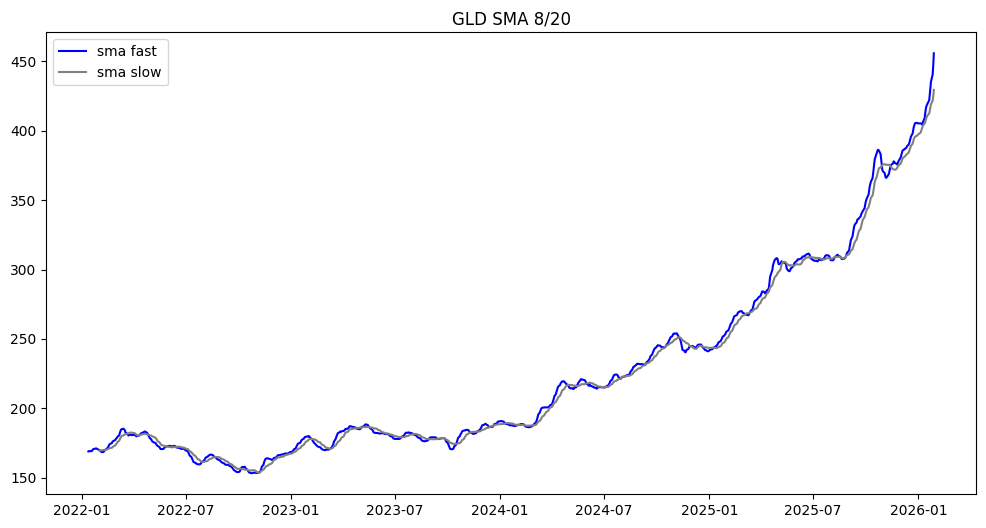

In [11]:
plot_sma(df, ticker, FAST_SMA_PERIOD, SLOW_SMA_PERIOD)

In [12]:
macd_df = df[['macd','macd_signal','macd_histogram']]
display(macd_df)

,macd,macd_signal,macd_histogram
0,0.000000,0.000000,0.000000
1,0.098918,0.019784,0.079134
2,0.134606,0.042748,0.091858
3,-0.004095,0.033379,-0.037475
4,-0.052091,0.016285,-0.068376
...,...,...,...
1016,12.161199,9.185925,2.975274
1017,13.701362,10.089012,3.612350
1018,15.286376,11.128485,4.157891
1019,17.263393,12.355467,4.907926


Plotting MACD for GLD


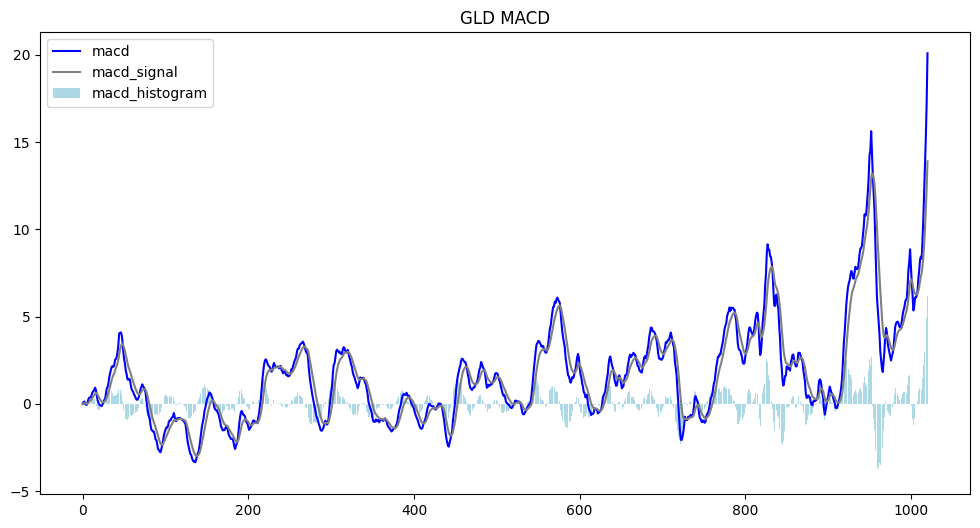

In [13]:
plot_macd(macd_df, ticker)

- When MACD line > signal line, histogram is positive
    - Shows bullish momentum and indicates potential long signal

Plotting RSI for GLD with rsi_period 7


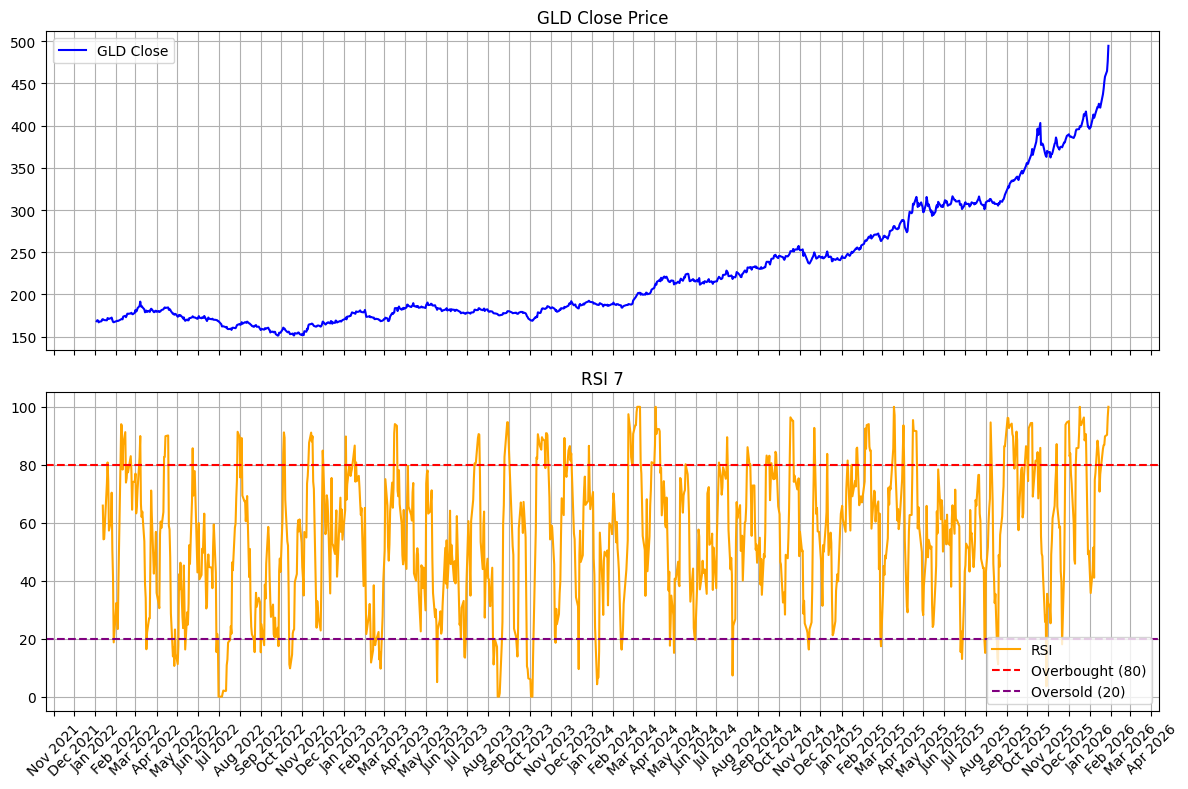

In [14]:
plot_rsi(df, ticker, RSI_PERIOD)

In [15]:
display(df)

,date,ticker,close_px,high_px,low_px,open_px,volume,sma_fast,sma_slow,macd,...,rsi,sma_cross_long,macd_cross_long,rsi_long_signal,rsi_recent,long_entry,long_exit,holding,trade,days_in_position
0,2022-01-03,GLD,168.330002,169.009995,168.000000,168.860001,9014400,NaN,NaN,0.000000,...,NaN,False,False,False,False,False,True,0,,0
1,2022-01-04,GLD,169.570007,169.720001,168.729996,168.899994,6965600,NaN,NaN,0.098918,...,NaN,False,True,False,False,False,True,0,,0
2,2022-01-05,GLD,169.059998,170.929993,168.899994,170.619995,8715600,NaN,NaN,0.134606,...,NaN,False,False,False,False,False,True,0,,0
3,2022-01-06,GLD,166.990005,167.750000,166.860001,167.160004,10902700,NaN,NaN,-0.004095,...,NaN,False,False,False,False,False,True,0,,0
4,2022-01-07,GLD,167.750000,168.009995,166.860001,167.369995,8191900,NaN,NaN,-0.052091,...,NaN,False,False,False,False,False,True,0,,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016,2026-01-22,GLD,451.790009,452.980011,443.559998,443.839996,19251200,430.880005,416.928003,12.161199,...,86.894657,False,False,True,True,False,True,0,,0
1017,2026-01-23,GLD,458.000000,458.750000,453.450012,454.109985,21531900,435.351254,419.146002,13.701362,...,89.818271,False,False,True,True,False,True,0,,0
1018,2026-01-26,GLD,464.700012,469.279999,460.359985,466.779999,34156000,440.735004,421.784503,15.286376,...,90.324606,False,False,True,True,False,True,0,,0
1019,2026-01-27,GLD,476.100006,476.489990,463.950012,465.070007,28386200,447.005005,424.752504,17.263393,...,96.411647,False,False,True,True,False,True,0,,0


## Backtest Strategy
#### Market-On-Close Execution
- Execute trade at or as close as possible to the official closing price of a trading day
- Signal at today's close -> trade executed at today's close -> PnL starts tomorrow


In [16]:
# Backtest strategy
initial_capital = 100000
allocation = 0.5 # 50% of capital
cost_per_shr = 0.005 # USD per share. Sometimes its cost_per_trade but assumption here is cost per share


In [17]:
display(df[(df['long_entry']==True) ]) #| (df['long_exit']==True)
# display(df[(df['position']==1)])

,date,ticker,close_px,high_px,low_px,open_px,volume,sma_fast,sma_slow,macd,...,rsi,sma_cross_long,macd_cross_long,rsi_long_signal,rsi_recent,long_entry,long_exit,holding,trade,days_in_position
26,2022-02-09,GLD,171.210007,171.419998,170.550003,170.679993,8002800,169.321251,169.922501,0.223526,...,93.333588,False,True,True,True,True,True,1,BUY,1
28,2022-02-11,GLD,173.809998,174.199997,170.710007,170.750000,25741500,170.327501,170.096000,0.570968,...,86.814824,True,False,True,True,True,True,1,BUY,1
68,2022-04-11,GLD,182.369995,183.330002,181.110001,183.169998,10071300,180.449999,180.441000,0.441948,...,63.694346,True,False,True,True,True,True,1,BUY,1
69,2022-04-12,GLD,183.770004,184.639999,182.960007,184.039993,12024600,180.840000,180.685000,0.649881,...,82.695368,False,True,True,True,True,True,0,SELL,0
97,2022-05-23,GLD,172.830002,173.380005,172.279999,173.130005,5518500,170.609999,173.160500,-2.123718,...,67.592622,False,True,True,True,True,True,1,BUY,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
916,2025-08-28,GLD,315.029999,315.079987,313.070007,313.320007,9610200,310.143742,309.832994,1.023213,...,86.418046,True,False,True,True,True,True,1,BUY,1
969,2025-11-12,GLD,385.989990,387.459991,379.440002,380.070007,16203700,372.028751,375.414500,3.935426,...,77.749118,False,True,True,True,True,True,1,BUY,1
971,2025-11-14,GLD,375.959991,378.200012,370.890015,372.869995,15198000,375.494999,374.084000,4.076898,...,65.547856,True,False,True,True,True,True,1,BUY,1
979,2025-11-26,GLD,383.119995,383.779999,380.459991,381.059998,9184100,376.684998,374.339499,3.228493,...,93.811883,False,True,True,True,True,True,1,BUY,1


In [18]:
# Generate portfolio positions, trades, pnl, returns
df = generate_portfolio(df, execution_params)

Calculating Positions and Trades...
Calculating Pnl...
Calculating Returns...


In [19]:
display(df[['date', 'long_entry', 'long_exit', 'holding', 'position', 'position_shrs']])
display(df[df['trade']!=''][['date', 'long_entry', 'long_exit', 'holding', 'position', 'position_shrs','trade']])

,date,long_entry,long_exit,holding,position,position_shrs
0,2022-01-03,False,True,0,0.0,0.0
1,2022-01-04,False,True,0,0.0,0.0
2,2022-01-05,False,True,0,0.0,0.0
3,2022-01-06,False,True,0,0.0,0.0
4,2022-01-07,False,True,0,0.0,0.0
...,...,...,...,...,...,...
1016,2026-01-22,False,True,0,0.0,120.0
1017,2026-01-23,False,True,0,0.0,120.0
1018,2026-01-26,False,True,0,0.0,120.0
1019,2026-01-27,False,True,0,0.0,120.0


,date,long_entry,long_exit,holding,position,position_shrs,trade
26,2022-02-09,True,True,1,50000.0,292.0,BUY
27,2022-02-10,False,True,0,0.0,0.0,SELL
28,2022-02-11,True,True,1,50000.0,287.0,BUY
29,2022-02-14,False,True,0,0.0,0.0,SELL
68,2022-04-11,True,True,1,50000.0,274.0,BUY
...,...,...,...,...,...,...,...
972,2025-11-17,False,True,0,0.0,0.0,SELL
979,2025-11-26,True,True,1,50000.0,130.0,BUY
980,2025-11-28,False,True,0,0.0,0.0,SELL
1008,2026-01-09,True,True,1,50000.0,120.0,BUY


In [20]:
display(df[df['trade']!=''])
display(df)

,date,ticker,close_px,high_px,low_px,open_px,volume,sma_fast,sma_slow,macd,...,days_in_position,position,position_shrs,trade_shrs,trade_cost,daily_ret_c2c,daily_pnl,cum_pnl,cum_ret,cum_ret_pct
26,2022-02-09,GLD,171.210007,171.419998,170.550003,170.679993,8002800,169.321251,169.922501,0.223526,...,1,50000.0,292.0,292,1.460,0.003399,-1.460000,99998.540000,1.017109,-0.001460
27,2022-02-10,GLD,170.559998,171.990005,170.460007,170.520004,10693500,169.630001,169.913500,0.274726,...,0,0.0,0.0,0,0.000,-0.003797,-189.828027,99808.711973,1.013248,-0.191288
28,2022-02-11,GLD,173.809998,174.199997,170.710007,170.750000,25741500,170.327501,170.096000,0.570968,...,1,50000.0,287.0,287,1.435,0.019055,-1.435000,99807.276973,1.032555,-0.192723
29,2022-02-14,GLD,174.740005,175.000000,173.679993,173.779999,13650700,171.065002,170.349500,0.870748,...,0,0.0,0.0,0,0.000,0.005351,267.535800,100074.812773,1.038080,0.074813
68,2022-04-11,GLD,182.369995,183.330002,181.110001,183.169998,10071300,180.449999,180.441000,0.441948,...,1,50000.0,274.0,274,1.370,0.004959,-1.370000,100073.442773,1.083408,0.073443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
972,2025-11-17,GLD,371.649994,375.459991,368.519989,374.040009,13295200,376.137497,372.509000,3.471375,...,0,0.0,0.0,0,0.000,-0.011464,-573.198965,98986.820527,2.207865,-1.013179
979,2025-11-26,GLD,383.119995,383.779999,380.459991,381.059998,9184100,376.684998,374.339499,3.228493,...,1,50000.0,130.0,130,0.650,0.007998,-0.650000,98986.170527,2.276005,-1.013829
980,2025-11-28,GLD,387.880005,388.000000,384.989990,385.980011,7175400,378.713749,375.226999,3.831454,...,0,0.0,0.0,0,0.000,0.012424,621.216567,99607.387095,2.304283,-0.392613
1008,2026-01-09,GLD,414.470001,415.290009,411.799988,413.220001,14011200,406.326252,403.850002,6.457208,...,1,50000.0,120.0,120,0.600,0.007242,-0.600000,99606.787095,2.462247,-0.393213


,date,ticker,close_px,high_px,low_px,open_px,volume,sma_fast,sma_slow,macd,...,days_in_position,position,position_shrs,trade_shrs,trade_cost,daily_ret_c2c,daily_pnl,cum_pnl,cum_ret,cum_ret_pct
0,2022-01-03,GLD,168.330002,169.009995,168.000000,168.860001,9014400,NaN,NaN,0.000000,...,0,0.0,0.0,0,0.0,0.000000,0.0,100000.000000,1.000000,0.000000
1,2022-01-04,GLD,169.570007,169.720001,168.729996,168.899994,6965600,NaN,NaN,0.098918,...,0,0.0,0.0,0,0.0,0.007367,0.0,100000.000000,1.007367,0.000000
2,2022-01-05,GLD,169.059998,170.929993,168.899994,170.619995,8715600,NaN,NaN,0.134606,...,0,0.0,0.0,0,0.0,-0.003008,-0.0,100000.000000,1.004337,0.000000
3,2022-01-06,GLD,166.990005,167.750000,166.860001,167.160004,10902700,NaN,NaN,-0.004095,...,0,0.0,0.0,0,0.0,-0.012244,-0.0,100000.000000,0.992039,0.000000
4,2022-01-07,GLD,167.750000,168.009995,166.860001,167.369995,8191900,NaN,NaN,-0.052091,...,0,0.0,0.0,0,0.0,0.004551,0.0,100000.000000,0.996554,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016,2026-01-22,GLD,451.790009,452.980011,443.559998,443.839996,19251200,430.880005,416.928003,12.161199,...,0,0.0,120.0,0,0.0,0.018463,0.0,100542.923575,2.683954,0.542924
1017,2026-01-23,GLD,458.000000,458.750000,453.450012,454.109985,21531900,435.351254,419.146002,13.701362,...,0,0.0,120.0,0,0.0,0.013745,0.0,100542.923575,2.720846,0.542924
1018,2026-01-26,GLD,464.700012,469.279999,460.359985,466.779999,34156000,440.735004,421.784503,15.286376,...,0,0.0,120.0,0,0.0,0.014629,0.0,100542.923575,2.760649,0.542924
1019,2026-01-27,GLD,476.100006,476.489990,463.950012,465.070007,28386200,447.005005,424.752504,17.263393,...,0,0.0,120.0,0,0.0,0.024532,0.0,100542.923575,2.828373,0.542924


In [21]:
exit_df = df.copy()
exit_df = exit_df[exit_df['long_exit']==True]
display(exit_df[['date', 'ticker', 'close_px', 'rsi_long_signal', 'sma_cross_long', 'macd_cross_long', 'long_exit']])

,date,ticker,close_px,rsi_long_signal,sma_cross_long,macd_cross_long,long_exit
0,2022-01-03,GLD,168.330002,False,False,False,True
1,2022-01-04,GLD,169.570007,False,False,True,True
2,2022-01-05,GLD,169.059998,False,False,False,True
3,2022-01-06,GLD,166.990005,False,False,False,True
4,2022-01-07,GLD,167.750000,False,False,False,True
...,...,...,...,...,...,...,...
1016,2026-01-22,GLD,451.790009,True,False,False,True
1017,2026-01-23,GLD,458.000000,True,False,False,True
1018,2026-01-26,GLD,464.700012,True,False,False,True
1019,2026-01-27,GLD,476.100006,True,False,False,True


In [22]:
date_str = dtt.now(pytz.timezone('America/New_York')).strftime('%Y_%m_%d')
strategy_id = f'sma_macd_rsi_{date_str}'


### Metrics

In [23]:
# Metrics
metrics_df = calc_metrics(df, ticker)
display(metrics_df)

Calculating Metrics for ticker GLD
total_return: 193.8%
sharpe: 1.71%
max_drawdown: -0.21%
total_pnl: $542.92


,ticker,total_return,sharpe_ratio,max_drawdown,total_pnl
0,GLD,193.8,1.71,-0.21,542.92


In [24]:
metrics_dir = f'{PROJECT_ROOT}/results/metrics/{strategy_id}'
if metrics_dir is not None:
    os.makedirs(metrics_dir, exist_ok=True)
trades_df = calc_trades(df, strategy_id)
trade_metrics_df = calc_trades_metrics(df, ticker, strategy_id, metrics_dir)
recent_trades_df = get_recent_trades(trades_df, ticker, strategy_id, metrics_dir)


entries: 61, exits: 61
trade_pnl: 
    trade_id   daily_pnl
0          1 -191.288027
1          2  266.100800
2          3  382.467581
3          4  374.647993
4          5  316.991660
..       ...         ...
56        57  481.705089
57        58 -404.799926
58        59 -573.858965
59        60  620.566567
60        61  935.536481

[61 rows x 2 columns]
Profitable Trades: 25
Non-Profitable Trades: 36
Total Trades: 61
% of profitable trades: 40.98
Average PnL per Trade: $8.9

trades_metrics_df:
               strategy_id  entries  exits  profitable_trades  \
0  sma_macd_rsi_2026_02_26       61     61                 25   

   non_profitable_trades  total_trades  pct_profitable  avg_pnl_per_trade  
0                     36            61           40.98                8.9  

recent_trades_df:
                  strategy_id       date  long_entry  long_exit  position  \
1011  sma_macd_rsi_2026_02_26 2026-01-14       False       True       0.0   
1012  sma_macd_rsi_2026_02_26 2026-01-15   

In [25]:
display(trade_metrics_df)
print(trade_metrics_df.columns)

,strategy_id,entries,exits,profitable_trades,non_profitable_trades,total_trades,pct_profitable,avg_pnl_per_trade
0,sma_macd_rsi_2026_02_26,61,61,25,36,61,40.98,8.9


Index(['strategy_id', 'entries', 'exits', 'profitable_trades',
       'non_profitable_trades', 'total_trades', 'pct_profitable',
       'avg_pnl_per_trade'],
      dtype='str')


In [26]:
display(trades_df.tail(10)[['date', 'long_entry', 'long_exit', 'position', 'position_shrs', 'trade', 'trade_shrs', 'trade_id']])
display(trades_df[trades_df['trade_id'].notna()].tail(10)[['date', 'long_entry', 'long_exit', 'position', 'position_shrs', 'trade', 'trade_shrs', 'trade_id']])
display(trades_df[trades_df['trade_id'].isin([1,2,3,4])][['date', 'long_entry', 'long_exit', 'position', 'position_shrs', 'trade', 'trade_shrs', 'trade_id']])

,date,long_entry,long_exit,position,position_shrs,trade,trade_shrs,trade_id
1011,2026-01-14,False,True,0.0,120.0,,0,<NA>
1012,2026-01-15,False,True,0.0,120.0,,0,<NA>
1013,2026-01-16,False,True,0.0,120.0,,0,<NA>
1014,2026-01-20,False,True,0.0,120.0,,0,<NA>
1015,2026-01-21,False,True,0.0,120.0,,0,<NA>
1016,2026-01-22,False,True,0.0,120.0,,0,<NA>
1017,2026-01-23,False,True,0.0,120.0,,0,<NA>
1018,2026-01-26,False,True,0.0,120.0,,0,<NA>
1019,2026-01-27,False,True,0.0,120.0,,0,<NA>
1020,2026-01-28,False,True,0.0,120.0,,0,<NA>


,date,long_entry,long_exit,position,position_shrs,trade,trade_shrs,trade_id
916,2025-08-28,True,True,50000.0,158.0,BUY,158,57
917,2025-08-29,False,True,0.0,0.0,SELL,0,57
969,2025-11-12,True,True,50000.0,129.0,BUY,129,58
970,2025-11-13,False,True,0.0,0.0,SELL,0,58
971,2025-11-14,True,True,50000.0,132.0,BUY,132,59
972,2025-11-17,False,True,0.0,0.0,SELL,0,59
979,2025-11-26,True,True,50000.0,130.0,BUY,130,60
980,2025-11-28,False,True,0.0,0.0,SELL,0,60
1008,2026-01-09,True,True,50000.0,120.0,BUY,120,61
1009,2026-01-12,False,True,0.0,0.0,SELL,0,61


,date,long_entry,long_exit,position,position_shrs,trade,trade_shrs,trade_id
26,2022-02-09,True,True,50000.0,292.0,BUY,292,1
27,2022-02-10,False,True,0.0,0.0,SELL,0,1
28,2022-02-11,True,True,50000.0,287.0,BUY,287,2
29,2022-02-14,False,True,0.0,0.0,SELL,0,2
68,2022-04-11,True,True,50000.0,274.0,BUY,274,3
69,2022-04-12,True,True,0.0,0.0,SELL,0,3
97,2022-05-23,True,True,50000.0,289.0,BUY,289,4
98,2022-05-24,False,True,0.0,0.0,SELL,0,4


In [27]:
display(recent_trades_df)

,strategy_id,date,long_entry,long_exit,position,position_shrs,trade,trade_shrs,trade_id
1011,sma_macd_rsi_2026_02_26,2026-01-14,False,True,0.0,120.0,,0,<NA>
1012,sma_macd_rsi_2026_02_26,2026-01-15,False,True,0.0,120.0,,0,<NA>
1013,sma_macd_rsi_2026_02_26,2026-01-16,False,True,0.0,120.0,,0,<NA>
1014,sma_macd_rsi_2026_02_26,2026-01-20,False,True,0.0,120.0,,0,<NA>
1015,sma_macd_rsi_2026_02_26,2026-01-21,False,True,0.0,120.0,,0,<NA>
1016,sma_macd_rsi_2026_02_26,2026-01-22,False,True,0.0,120.0,,0,<NA>
1017,sma_macd_rsi_2026_02_26,2026-01-23,False,True,0.0,120.0,,0,<NA>
1018,sma_macd_rsi_2026_02_26,2026-01-26,False,True,0.0,120.0,,0,<NA>
1019,sma_macd_rsi_2026_02_26,2026-01-27,False,True,0.0,120.0,,0,<NA>
1020,sma_macd_rsi_2026_02_26,2026-01-28,False,True,0.0,120.0,,0,<NA>


In [28]:
metrics_df = pd.concat([metrics_df, trade_metrics_df], axis=1)
display(metrics_df)
metrics_df.to_csv(f'{metrics_dir}/metrics_{strategy_id}_{ticker.lower().replace("-","_")}.csv', index=False)


,ticker,total_return,sharpe_ratio,max_drawdown,total_pnl,strategy_id,entries,exits,profitable_trades,non_profitable_trades,total_trades,pct_profitable,avg_pnl_per_trade
0,GLD,193.8,1.71,-0.21,542.92,sma_macd_rsi_2026_02_26,61,61,25,36,61,40.98,8.9


#### Cumulative PnL / Equity Curve

Plotting Equity Curve for GLD with initial capital 100000


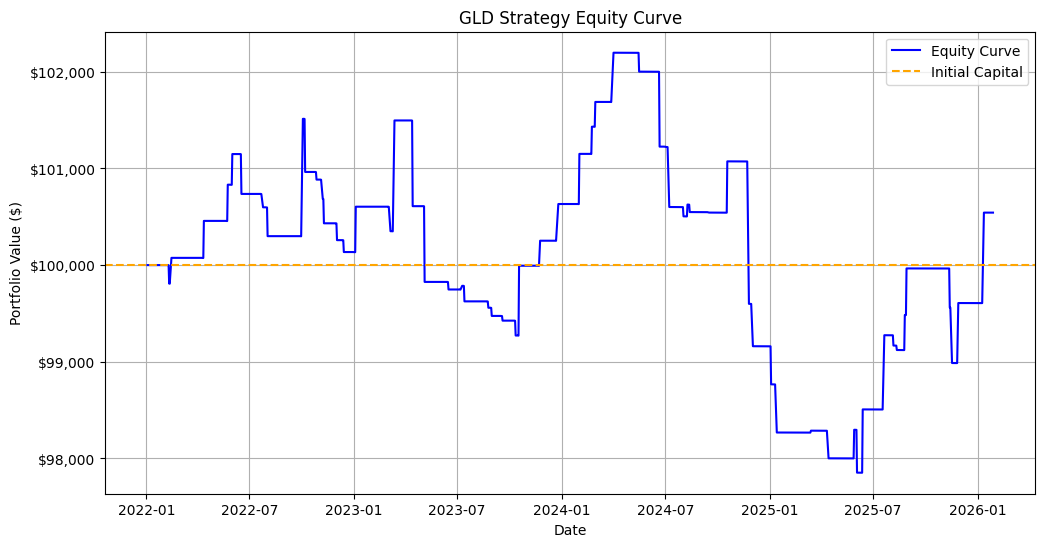

<Figure size 640x480 with 0 Axes>

In [29]:
plot_equity_curve(df, ticker, initial_capital)

### All metrics across different tickers

In [30]:
all_metrics_df = get_all_metrics_by_strategy(strategy_id)
display(all_metrics_df)

Retrieving all Metrics by strategy sma_macd_rsi_2026_02_26


,ticker,total_return,sharpe_ratio,max_drawdown,total_pnl,strategy_id,entries,exits,profitable_trades,non_profitable_trades,total_trades,pct_profitable,avg_pnl_per_trade
0,GLD,193.8,1.71,-0.21,542.92,sma_macd_rsi_2026_02_26,61,61,25,36,61,40.98,8.9


In [31]:
styled_metrics_df = style_metrics_df(all_metrics_df)
display(styled_metrics_df)

,ticker,total_return,sharpe_ratio,max_drawdown,total_pnl,strategy_id,entries,exits,profitable_trades,non_profitable_trades,total_trades,pct_profitable,avg_pnl_per_trade
0,GLD,$193.80,1.710000,-21.00%,$542.92,sma_macd_rsi_2026_02_26,61,61,25,36,61,40.98%,$8.90


- Sharpe ratio 1+ decent, 1.5 very good. 2+ excellent
- Max drawdown 20-40%
- Win rate 40-60%
- Avg pnl per trade > 0

